# Fun with MNIST
This lab will teach how to use Keras to build and train neural networks to solve simple computer vision tasks.

You will learn about

- The MNIST dataset
- Softmax regression
- Weight decay
- Keras' Sequential API and Functional API
- Convolutional Neural Networks (CNNs)
- Feature embedding (embedding MNIST images in 2D using a CNN)
- AutoEncoders
- Writing your own data generator

**Before we start - remember to set runtime to GPU**

## Task 1: Downloading and pre-processing the MNIST dataset
The MNIST dataset of handwritten digits is so commonly used that it comes with most deep learning frameworks, including Keras. Let's download the dataset and explore a little bit.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Examples of test images


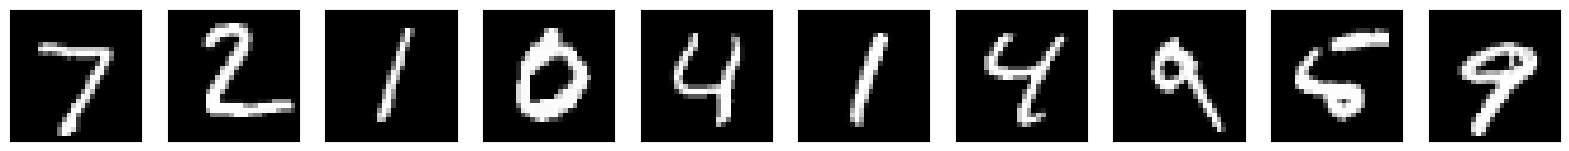

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt

# Utility function for showing images
def show_imgs(x_test, n=10):
    sz = x_test.shape[1]
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(sz,sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Examples of test images')
show_imgs(x_test)

In [6]:
x_train.shape
x_test.shape
y_test.shape

(10000, 10)

### Questions 1.1
1. What is the input shape?
(28, 28, 1)
2. How many training examples are there?
60000
3. How many test examples are there?
10000
4. What does `to_categorical` do? (Hint: print `y_test` before and after applying `to_categorial`).

## Task 2: Softmax regression
Now, let's define a tiny Keras model for logistic regression. Mathematically this model outputs a 10-dimensional vector `y` of class probabilities, where


```
y = softmax(W*x + b)
```

and
- `x` is a 28x28 = 784-dimensional vector corresponding to the input image,
- `W` is a 10 x 784 matrix of weights
- `b` is a 10-dimensional vector of biases

Defining models in Keras is not very intuitive from a mathematical perspective. Here is one way to implement the equation above using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). A Sequential model is a just a linear stack of layers.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

keras.utils.set_random_seed(0) # make weight initialization deterministic

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape)) # input_shape is (28, 28, 1)
model.add(Dense(num_classes)) # num_classes is 10
model.add(Activation('softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### Questions 2.1
1. What do you think the Flatten() layer does, and why is it necessary to have it here?
2. What do you think the Dense() layer does, and why does it have 7850 parameters?
(784×10)+10=7840+10=7850
3. What do you think Activation() does, and why is its argument set to "softmax"?
convert to probs
**Tip**

To answer questions like the ones above, you could perform simple experiments like the one below:

```
input_shape = (28, 28, 1)
x = tensorflow.random.normal(input_shape)
y = keras.layers.Flatten()(x)
print(y.shape)
```

### Training

Now, let's train the model for 10 epochs. We will be using the multi-class version of the cross entropy loss and stochastic gradient descent (SGD). The difference between normal gradient descent and SGD is that normal gradient descent calculates the gradients based on all training examples, whereas SGD approximates the gradient by calculating it on small batches (of size 128 in this example).

In [7]:
batch_size = 128
epochs = 10

# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5307 - loss: 1.6599 - val_accuracy: 0.8396 - val_loss: 0.8007
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8382 - loss: 0.7591 - val_accuracy: 0.8639 - val_loss: 0.6024
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.6036 - val_accuracy: 0.8747 - val_loss: 0.5231
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8669 - loss: 0.5348 - val_accuracy: 0.8807 - val_loss: 0.4786
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8748 - loss: 0.4942 - val_accuracy: 0.8853 - val_loss: 0.4494
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8796 - loss: 0.4667 - val_accuracy: 0.8895 - val_loss: 0.4284
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8836 - loss: 0.4466 - val_accuracy: 0.8920 - val_loss: 0.4125
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8859 - loss: 0.4311 - val_accuracy: 0.

In machine learning it is always a good idea to pick a simple **baseline model** that you can compare your own models to. We will refer to the classifier above as our baseline. You should expect the validation accuracy of our baseline model to be around 90% after training for 10 epochs.

### Model evaluation
For several reasons you always want to monitor how your model performs during training. The simplest way to monitor the training process is by plotting the loss and accuracy curves. Here we are doing it post-training, but there are tools that allow you to monitor the curves in real-time (see for instance [TensorBoard](https://www.tensorflow.org/tensorboard)).

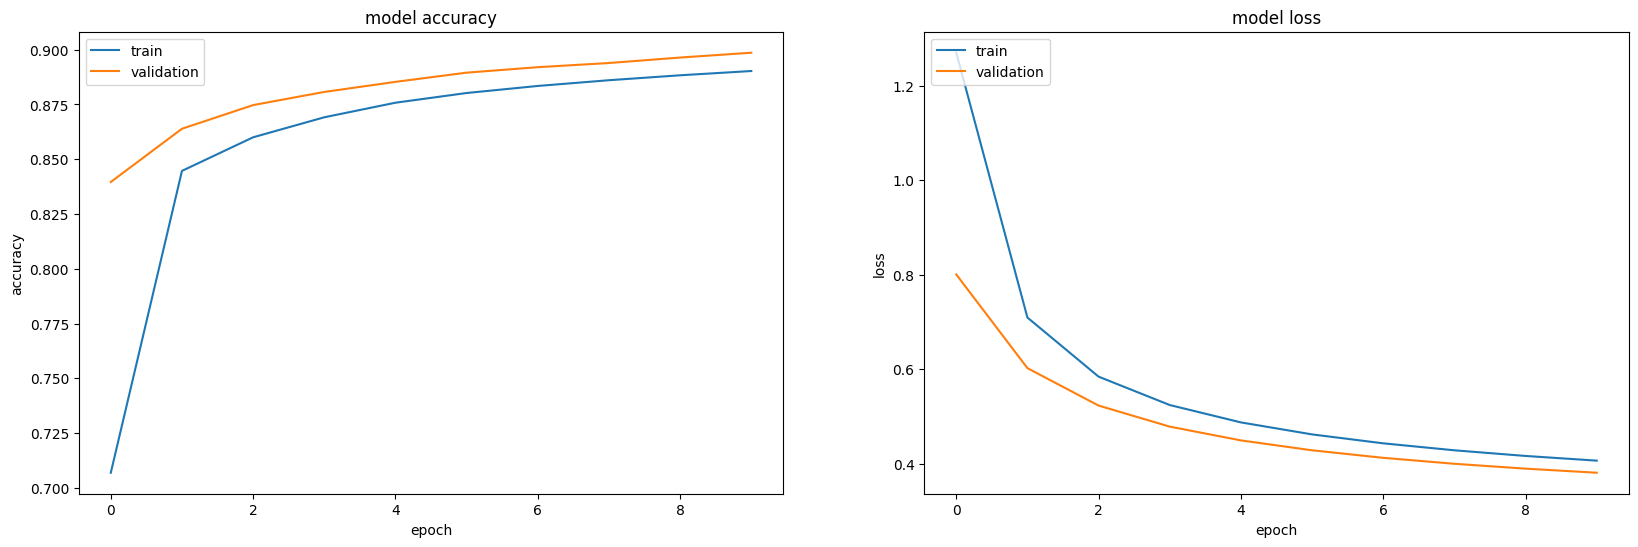

In [8]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

Examples of things you should be looking for:

- The loss should go down over time.
 - If it increases, it usually means that your learning rate was set too high.
 - If it doesn't decrease, it could indicate that your learning rate was set too low.
- If the validation loss starts increasing, while the training loss is still decreasing, it means that your model has started overfitting.
 - Can you explain why?
- Simply stated, your model is done training when the loss curves hit a low plateau.
 - Are we done training in the above example, or do you think we should we be training for more epochs?


### Task 2.1: Batch size and number of epochs
Training on the entire MNIST training data set is guaranteed to work (almost) always. Simply because of the large number of images in the training set. This is boring. So let's make our problem a little more challenging by reducing the number of training examples to just 10 samples from each class.

In [9]:
import numpy as np

np.random.seed(0) # make it deterministic

# create smaller training set
digit_indices = np.asarray([np.where(np.argmax(y_train,axis=1) == i)[0][np.random.randint(0,5000,10)] for i in range(num_classes)]).flatten()
x_train_small = x_train[digit_indices,:]
y_train_small = y_train[digit_indices,:]

**Note:** Set verbose=1 to print output while training.

In [ ]:
import time

batch_size = 5 # Cannot use 128 like before, because we only have 100 samples (10 from each class)
epochs = 20 # We need more epochs because we have fewer training samples

keras.utils.set_random_seed(0)

# Model (redefine the model in order to reinitialize the weights to random values)
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model before training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model (this will take a little while. Set verbose to 1 if you want to see how training progresses)
start_time = time.time()
history = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            verbose=1,
            shuffle=True)
print("--- training tool %s seconds ---" % (time.time() - start_time))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# Plot old vs new loss
show_history(history)

**Note:** Although we didn't change the underlying equation of our baseline model (`y = softmax(Wx+b)`), we did change the nature of the data on which the model was trained, and we also lowered the batch size and increased the number of epochs. So this is considered a **new model** that we could compare to our baseline model.

### Questions 2.2
1. Our new model performs worse than the baseline model. Why?
2. This puzzle is supposed to make you speculate. You are not required to get the answers right at this stage of the course. Temporarily set the number of epochs to 10 to make experimentation faster. How does training behave when we set the batch size to the values listed below? Compare the loss curves and the training times and see if you can figure out why they differ the way they do. Use these batch sizes:
 - 1 (lowest possible)
 - 5 (low)
 - 20 (medium)
 - 100 (highest possible)
3. Above, we changed the batch size and the number of epochs. Are these *hyperparameters* or *learnable parameters*? Btw., what are the learnable parameters of our model (``y = softmax(W*x + b)``)?
4. Which criteria would you pick to determine the "optimal" combination of batch size and number of epochs?

**IMPORTANT:** Before continuing to the next task, retrain the model above using a batch size of 5 and number of epochs set to 20.

### Task 2.2: Finding a better learning rate
The learning rate is another hyperparameter that we can tweak.

Training with the default learning rate (which is 0.01) is rather slow. Your task is to find a better learning rate that makes the model converge faster, without comprimising the model's accuracy on the validation set. With a proper learning rate you should be able to achieve 74-75% accuracy in just 10 epochs (instead of 20 as above).

You can adjust the learning rate by setting the `learning_rate` argument of keras.optimizer.SGD:

```
keras.optimizers.SGD(learning_rate=0.01)
```

**Optional bonus questions:** What happens if you set the learning rate way too low (e.g. 0.0001)?


### Task 2.3: Displaying the learned weights
In the case of softmax regression there is a very intuitive interpretation of the learned weights of the coefficient matrix `W`, as you will see below.

First, your task is to extract the weights of the coefficient matrix from the model (i.e. the `Dense` layer) and display each row as an image.

In [ ]:
W = # Your code goes here
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

### Questions 2.3
1. How do we interpret the weights?
2. In some regions the weights are very noisy. What could be the consequences of that?

### Task 2.4: Weight decay (or L2 regularization)
With only 10 observations per class in our training data set, it is very likely that our model overfits the training data. This leads to poor generalization (i.e., the model doesn't work that well on unseen data).

One way to address overfitting is by means of regularization. The best kind of regularization is "adding more data" (of course). This is the reason that our baseline model performs better than the current model.

One possible regularization strategy is to use *weight decay*. So let's modify the loss function of the model by adding an L2 regularization term. The regularization term is added using an extra parameter to the Dense layer.

Please note that the weight of the penalty term (`lamda`) has been set rather high in the example below. As a consequence, you will actually see a small decrease in validation accuracy. But as you will see later, weight decay has dramatic effect on the learned weights (`W`). By the way, `lambda` is yet another hyperparameter that we could tweak to make our model perform better.

In [ ]:
batch_size = 5
epochs = 20

keras.utils.set_random_seed(0)

# lamda is the weight of the L2 penalty term
lamda = 0.1
L2_regularizer = keras.regularizers.l2(lamda)

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes,
                activation='softmax',
                kernel_regularizer=L2_regularizer))

# Training
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])
history_reg = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# Plot loss
print("Loss curves with regularization")
show_history(history_reg)

**Now comes the interesting part:** Try once more to display the weights - this time of the regularized model.

In [ ]:
#W = # Your code goes here
W = W.reshape((28,28,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

### Questions 2.4
1. How do the weights of the regularized model differ from the weights of the non-regularized model?
2. Can you explain why?

### Functional API instead of Sequential API
The models above have been specified using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). Keras also allows you to specify models using the [Functional API](https://keras.io/getting-started/functional-api-guide/). The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

Here is how to set up the (baseline) softmax regression model using the functional API:

In [ ]:
from keras.layers import Input
from keras.models import Model

keras.utils.set_random_seed(0)

# This returns a tensor
inputs = Input(shape=input_shape)

# A layer instance is callable on a tensor, and returns a tensor
x = Flatten()(inputs)
x = Dense(num_classes)(x)
predictions = Activation('softmax')(x)

# This creates a model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

# Training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

## Task 3: Our first CNN
It's time to move on and build our first CNN.

Here is a simple example:

In [ ]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model

keras.utils.set_random_seed(0)

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(units=64, activation='relu')(encoded)
x = Dropout(rate=0.5)(x)
predictions = Dense(units=num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

### Questions 3.1
1. How many layers does this CNN have?
2. How many convolution filters are there in the first convolution layer, and what is the width and height of the filters?
3. What does the MaxPooling2D layer do?
4. What does the Dropout layer do?
5. What is the shape of the output of the last convolution layer (i.e., just before the flatten layer)

**Recall**

You can make small experiments like this one

```
input_shape = (1, 28, 28, 1) # Dimensions are (batch_size, height, width, num_channels)
x = tensorflow.random.normal(input_shape)
y = keras.layers.Conv2D(filters=2, kernel_size=3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
print(y.shape)
```

**Optional bonus task:** See if you can figure out a way to display the filters of the first convolution layer as images.

For the record, the same model can also be defined using the sequential API:


```
from keras.layers import Dropout
from keras.layers import Conv2D ![alt text](https://), MaxPooling2D

input_img = Input(shape=(28, 28, 1))
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64,
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
```



### Training
Let's train our model on the small dataset and evaluate it on the validation set:

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_small, y_train_small,
                    batch_size=10,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Valdiation accuracy:', score[1])

In [ ]:
show_history(history)

Notice how this model is able to achieve a higher validation accuracy on the small training dataset (before we got 74.4%, now we have 80%). It does come at an expense, however; the CNN model needs to train for longer, having to do with the fact that it has more layers and more learnable parameters.

**Note:** If you train the above CNN model on the full MNIST dataset, you can expect to get at least 97-98% validation accuracy. That is quite an improvement over our baseline model (softmax regression), which got 89%.

### Task 3.1 Encoding the MNIST dataset in 2 dimensions with a CNN
In the above model the input shape to the Flatten layer  is 3x3x32, which is then flattened to a 288-dimensional vector, corresponding to the variable named `encoded`.

Your task is to modify the network such that variable `encoded` has dimensionality 2 instead of 288.

*Hint:* You could insert an extra layer before the Flatten layer that reduces the 3x3x32 input tensor to a 1x1x2 tensor. There are several solutions. It might be a good idea to add an activation function to the layer that you add. I used `activation='tanh'`. I will explain in the solution why this is a good idea.

In [ ]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

keras.utils.set_random_seed(0)

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = # Your code goes here
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

### Training
This time we train the model on the full dataset, because compressing the images to 2 dimensions is a difficult task that requires more training data.

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Task 3.2
Run all test examples (`x_test`) through your model and for each example extract the 2-dimensional vector output of the Flatten layer (variable named `encoded`). To make predictions on a batch of images, you can do like this: ``out = model_encoded.predict(batch)``.

Then plot those vectors in a 2D plot, where each class gets its own color.

You might find this code useful:

In [ ]:
model_encoded = Model(inputs=model.input, outputs=encoded)

# Plot 10 dots with 10 different colors
for i in range(10):
  plt.plot(i,i,'.C'+str(i))

### Comment
The point of this little exercise is really to illustrate the power of CNNs as image encoders. Think of what we have just accompplished: We have embedded 28x28=784 dimensional images/vectors down to just 2 dimensions, and we can still distinguish the 10 classes from each other! This is a really powerful concept for visualizing high-dimensional data in 2D.

## Task 4: Convolutional Autoencoder
Autoencoders are special types of neural networks that map the input X to the same output (namely X). So the autoencoder (AE) is an identity function:

```
X = AE(X)
```

So what's the point? The point is that the autoencoder compresses the image down to a low-dimensional representation, which can be decoded again to reconstruct the original input image. This has many useful applications, such as data compression and representation learning. Only the important information is stored in the low-dimensional representation.

The autoencoder consists of a trained encoder (E) and a trained decoder (D):

```
X = AE(X) = D(E(X))
```

It is typically (but not always) the encoding E(X) that we are interested in.

Note that the autoecoder does not need the class labels to train. So it is an **unsupervised** machine learning technique.

Here is an example of a convolutional autoencoder:

In [ ]:
from keras.layers import UpSampling2D

keras.utils.set_random_seed(0)
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print("shape of encoded", encoded.shape)

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid')(x)
print("shape of decoded", decoded.shape)

autoencoder = Model(inputs, decoded)
autoencoder.summary()

### Questions 4.1
1. What is the shape of the encoded image?
2. Why are we not flattening (i.e., vectorizing) the encoded image like we did in the CNN classifier above?
3. What does UpSampling2D do?
4. Why do you think upsampling is followed by a convolution? Hint: It has to do with the way we are upsampling...
5. See if you can figure out what `padding` means. What is the difference between using `padding='same'` and `padding='valid'`?

**Again** remember that you can carry out small experiments to get the answers.

### Training
Let's train the autoencoder:

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='mse')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

And show some test results

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

### Improving the autoencoder
This is okay, but not great. Let's use binary cross entropy (BCE) loss instead of mean squared error (MSE) loss. Using BCE assumes that the inputs are a probabilities, hence the sigmoid below to squash the values in between 0 and 1.

In [ ]:
decoded_sigmoid = Activation('sigmoid')(decoded) # decoded is the output of the first autoencoder
autoencoder2 = Model(inputs, decoded_sigmoid)
autoencoder2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy')
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

In [ ]:
decoded_imgs = autoencoder2.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

### Questions 4.2
1. What is the difference between 'mse' loss and 'binary_crossentropy' loss?
2. Can you explain why 'binary_crossentropy' works better?

## Task 5: Denoising Autoencoder
Autoencoders can get really advanced, like [Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). A slightly less complicated, yet powerful autoecoder variant is the [Denoising Autoencoder](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).

As stated above autoencoders have many useful applications. One of these is *noise reduction*. The underlying idea is very simple: Add random noise to the input X, and teach the autoencoder to remove the noise. That is, the autoencoder should learn the mapping:

```
X = AE(X + noise)
```

### Task 5.1
Create two new data sets based on x_train and x_test, where you have added noise such that

```
x_train_noisy = x_train + noise
x_test_noisy = x_test + noise
```

You may want to look at numpy functions like [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) and [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html).

**Your tasks:**

1. Does ``autoencoder2`` work on the noisy images, ``x_test_noisy``? (test it!)
2. Retrain ``autoencoder2`` on the noisy images (input = ``x_train_noisy`` and output = ``x_train``). What do you observe?

How much noise can you add before the autoencoder breaks down (fails to remove the noise)?

In [ ]:
#Your code goes here
#x_train_noisy = ???
#x_test_noisy = ???

Let's first verify that the existing autoencoder doesn't work well on noisy input images:

In [ ]:
# denoising
print("denoising")
decoded_imgs = autoencoder2.predict(x_test_noisy)
print("input (upper row)")
show_imgs(x_test_noisy)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

Doesn't look that good. Let's see if we can teach the model to remove the noise by showing it training images that contain noise. Instead of training from scratch, we will *fine-tune* the model that has already been trained:

In [ ]:
# it takes more epochs to converge
autoencoder2.fit(x_train_noisy, x_train, epochs=10, batch_size=100,
                shuffle=True, validation_data=(x_test_noisy, x_test))

In [ ]:
# denoising
print("denoising")
decoded_imgs = autoencoder2.predict(x_test_noisy)
print("input (upper row)")
show_imgs(x_test_noisy)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

Pretty cool, right?

Of cause the updated autoencoder still works on the noise-free images:

In [ ]:
# what if we feed the original noise-free test images?
decoded_imgs = autoencoder2.predict(x_test)
print("\nof course, it works with original noise-less images")
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

## Task 6: Image regression
Recall that in a regression problems the output of the model is one or more scalar values, rather than class labels. Both the autoencoder and super resolution network are examples of regression models. Another example of image regression is [facial landmark prediction](https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf), which can be used for emotion recognition.

In this task we will estimate the rotation angle of rotated MNIST images (but it could just as well have been estimating pixel coordinates of facial landmarks).

As a first step, we need an image generator that generates batches of randomly rotated images, along with the target rotation angles that the model should learn to predict. This code was modified from https://d4nst.github.io/2017/01/12/image-orientation/

**Optional bonus task:** Writing your own custom data generators is a common task in deep learning. Once you have completed the main task, consider going through the code of  `RotNetDataGenerator` and see if you can figure out how it works (notice that its base class is [`https://keras.io/api/utils/python_utils#pydataset-class`](https://keras.io/api/utils/python_utils#pydataset-class)).

In [ ]:
import cv2

class RotNetDataGenerator(keras.utils.PyDataset):

    def __init__(self, input, batch_size=64):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]

        # Add dimension because the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, idx):
        # create array to hold the images
        batch_x = np.zeros((self.batch_size,) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(self.batch_size, dtype='float32')

        indices = [i for i in range(self.batch_size*idx, self.batch_size*(idx+1))]

        # iterate through the current batch
        for i, j in enumerate(indices):

            image = self.images[j].squeeze()

            # get a random angle
            rotation_angle = np.random.randint(-30,30)

            # rotate the image
            rows,cols = image.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
            rotated_image = cv2.warpAffine(image,M,(cols,rows))

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        return batch_x, batch_y

### Test the generator

In [ ]:
# Instantiate
datagen = RotNetDataGenerator(
        x_train,
        batch_size=32,
    )

# Generate batch
rotated_images, angles = datagen.__getitem__(0)

# Display
print("Images (before rotation)")
show_imgs(x_train)
print("Images after random rotation")
show_imgs(rotated_images)

### Task 6.1
Make a small CNN that takes as input an 28x28x1 image and outputs a single scalar value (the rotation angle).

The last layer of your network should be

```
angle = Dense(1)(x)
```

Note that this is a dense layer **without** any activation function, hence the output of this layer is simply `angle = W*x + b`.

In [ ]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
# Your codes goes here

# Decoder (predict angle)
x = # Your code goes here
angle = Dense(1)(x)

angle_estimator = Model(input=inputs, output=angle)

### Training

In [ ]:
angle_estimator.compile(optimizer='rmsprop',loss='mse')

# training loop
angle_estimator.fit(
    RotNetDataGenerator(
        x_train,
        batch_size=100
    ),
    epochs=50,
    validation_data=RotNetDataGenerator(
        x_test,
        batch_size=100
    ))

### Model evaluation

In [ ]:
# Set up generator
datagen = RotNetDataGenerator(
        x_test,
        batch_size=32
    )

# Generate test images
rotated_images, angles = datagen.__getitem__(0)
print("Test images before rotation")
show_imgs(x_test)
print("Test images after rotation")
show_imgs(rotated_images)

# Predict angles
angles_pred = angle_estimator.predict(rotated_images)

# Plot angles
print('Predicted vs. true rotation angles')
plt.plot(angles)
plt.plot(angles_pred)
plt.legend(['True','Predicted']);
plt.xlabel('Test image')
plt.ylabel('Rotation angle')

**HELP**: The predicted angles should match the true angles reasonably well. If your model fails to predict the angles, it could be because the model is underfitting. This indicates that the capacity of the model is too low. To increase capacity, add more connections in dense layers and/or more output maps in convolutional layers (I will explain this in the class).

### De-rotate images
Now that we have estimated the rotation angles, let's de-rotate the images back to their original alignment.

In [ ]:
de_rotated_images = np.zeros(rotated_images.shape)

for i in range(rotated_images.shape[0]):
  image = rotated_images[i,:,:,:].squeeze()

  # get predicted angle
  rotation_angle = -angles_pred[i]

  # rotate the image
  rows,cols = image.shape
  M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),float(rotation_angle),1)
  de_rotated_image = cv2.warpAffine(image,M,(cols,rows))

  de_rotated_images[i,:,:,0] = de_rotated_image

print('Images before rotation (ground truth)')
show_imgs(x_test)
print('Images after rotation (to be de-rotated)')
show_imgs(rotated_images)
print('De-rotated images (should match ground truth)')
show_imgs(de_rotated_images)

## Bonus tasks
In case you completed all of the above and you still have time left, here are some ideas for extra tasks:

### Super resolution
The convolutional autoencoder is a network that maps an image to another image. There are other types of these image-to-image networks.

One example is a super resolution network. This is pretty much an autoencoder, except that the input image has lower spatial resolution than the output image. Super resolution networks learn to increase the spatial of the input image.

Your task is to modify the autoencoder such that it takes an 14x14x1 image as input and transforms it to a 28x28x1 image. Specifically, the training and test inputs should be

In [ ]:
# Low resolution images (pick every other pixel)
x_train_lowres = x_train[:,::2,::2,:] # 14x14x1
x_test_lowres = x_test[:,::2,::2,:] # 14x14x1

# Show example
print("Input low resolution images")
show_imgs(x_train_lowres)
print("Output high resolution images (target)")
show_imgs(x_train)

### Autoencoder based on U-net
One disadvantage of the autoencoder implemented above is that the fine image details are lost in the encoder, making them impossible to recover for the decoder. This results in output images that are more blurry than the input images.

One way to recover the fine details is through so-called *skip connections*, first introduced in the U-net architecture. See if you can figure out what it is and see of you can implement an autoencoder with skip connections.

![alt text](https://miro.medium.com/max/720/1*OkUrpDD6I0FpugA_bbYBJQ.png)

**Help:** Skip connections connect each layer of the encoder with a corresponding layer in the decoder (illustrated by the horizontal gray arrows in the figure above). There are many ways to implement skip connections. It is basically all about getting the shapes of the encoder and decoder to match.

**Useful links:**

- https://arxiv.org/pdf/1505.04597.pdf
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
